In [1]:
# Bloque 1: Importar bibliotecas necesarias
import glob
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



2025-06-21 01:57:03.951069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 01:57:03.951164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 01:57:03.970239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 01:57:03.995616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-21 01:57:06.348054: W tensorflow/compiler/tf2

In [2]:
# Verificamos que contamos con GPU y Cuda en tensorflow

print(f"Tensorflow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Cuda version: {tf.test.is_built_with_cuda()}")

Tensorflow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Cuda version: True


2025-06-21 01:57:10.098778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 01:57:10.184692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 01:57:10.185016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Bloque 2: Cargar y concatenar todos los CSV en un único DataFrame
ROOT_PATH = "./datasets"
csv_files = glob.glob(os.path.join(ROOT_PATH, "*.csv"))
# Leer cada CSV y concatenarlos
dataframe = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)



In [4]:
# -------------------------------
# Downsample aleatorio de steering_angle == 0
# -------------------------------
# Asegurar dtype float
dataframe['steering_angle'] = pd.to_numeric(dataframe['steering_angle'], errors='coerce')

# Separar ceros y no-ceros
zero_df     = dataframe[dataframe['steering_angle'].abs() < 1e-4]
non_zero_df = dataframe[dataframe['steering_angle'].abs() >= 1e-4]

print(f"Antes: zeros={len(zero_df)}, non-zeros={len(non_zero_df)}")

# Muestrear sólo un porcentaje de ceros
zero_keep_frac = 0.3  # ajusta esto (0.1 = conservar 10 % de los ceros)
zero_df = zero_df.sample(frac=zero_keep_frac, random_state=42)
print(f" Muestreando {len(zero_df)} ceros ({zero_keep_frac*100:.0f} %)")

# Reconstruir y mezclar
dataframe = (
    pd.concat([non_zero_df, zero_df], axis=0)
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

print(f"Después: zeros={ (dataframe['steering_angle'].abs()<1e-4).sum() }," 
      f" non-zeros={ (dataframe['steering_angle'].abs()>=1e-4).sum() }")

# Vista previa
dataframe.head()

Antes: zeros=8431, non-zeros=17672
 Muestreando 2529 ceros (30 %)
Después: zeros=2529, non-zeros=17672


,left_image,center_image,right_image,steering_angle,timestamp
0,2025-06-20_16-05-04/2025_06_20_16_05_24_796071...,2025-06-20_16-05-04/2025_06_20_16_05_24_796071...,2025-06-20_16-05-04/2025_06_20_16_05_24_796071...,0.02,2025_06_20_16_05_24_796071
1,2025-06-20_16-23-18/2025_06_20_16_23_44_511346...,2025-06-20_16-23-18/2025_06_20_16_23_44_511346...,2025-06-20_16-23-18/2025_06_20_16_23_44_511346...,-0.00,2025_06_20_16_23_44_511346
2,2025-06-19_18-34-48/2025_06_19_18_41_29_007307...,2025-06-19_18-34-48/2025_06_19_18_41_29_007307...,2025-06-19_18-34-48/2025_06_19_18_41_29_007307...,-0.06,2025_06_19_18_41_29_007307
3,2025-06-20_15-26-09/2025_06_20_15_26_52_685379...,2025-06-20_15-26-09/2025_06_20_15_26_52_685379...,2025-06-20_15-26-09/2025_06_20_15_26_52_685379...,-0.08,2025_06_20_15_26_52_685379
4,2025-06-20_16-10-48/2025_06_20_16_10_55_547585...,2025-06-20_16-10-48/2025_06_20_16_10_55_547585...,2025-06-20_16-10-48/2025_06_20_16_10_55_547585...,0.12,2025_06_20_16_10_55_547585


In [5]:
# Imprimimos el total de imagenes del datasframe de pandas
# Se multiplica por 3 porque cada imagen tiene 3 imagenes (center, left, right)
print(f"Total de imagenes en el dataset: {len(dataframe * 3)}")

Total de imagenes en el dataset: 20201


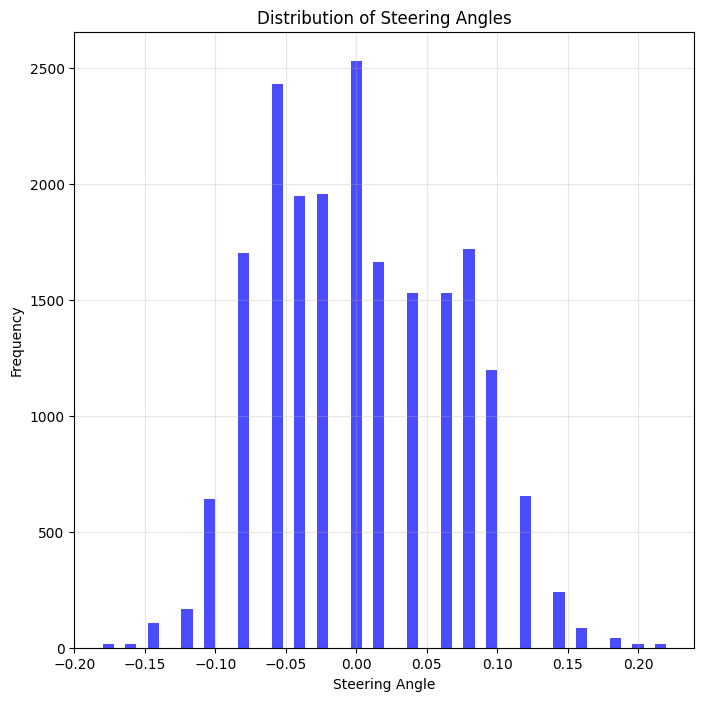

In [6]:
# Mostramos el histograma de los angulos de los datos de entrenamiento en el dataframe
plt.figure(figsize=(8, 8))
plt.hist(dataframe['steering_angle'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# Función para crear el dataset de tensorflow basado en el dataframe de pandas
# y las imagenes generadas previamente en el simulador
def create_tf_dataset(df, batch_size=32, img_height=66, img_width=200, steering_correction=0.02, is_training=True):
    """
    Creates a tf.data.Dataset from a DataFrame with image paths and steering angles.
    Features:
    - Memory-efficient loading with smaller shuffle buffer
    - Optimized caching strategy
    - Conditional data augmentation
    - Performance-optimized pipeline
    """
    # Definimos el path raiz de las imagenes
    root = tf.constant(ROOT_PATH)
    
    # Verificamos que contamos con GPU y Cuda en tensorflow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        try:
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    # Calculamos el tamaño del buffer de shuffling - usamos un buffer más pequeño para mejor eficiencia de memoria
    num_rows = df.shape[0]
    num_images = num_rows * 3  # 3 imagenes por fila (center, left, right)
    shuffle_buffer = min(num_images // 10, 1000)  # Buffer de shuffling más pequeño

    # Función para agregar una sombra aleatoria - solo usada en entrenamiento
    @tf.function
    def add_random_shadow(image):
        shape = tf.shape(image)
        h, w = shape[0], shape[1]
        x1, y1 = 0, tf.random.uniform([], 0, h, dtype=tf.int32)
        x2, y2 = w, tf.random.uniform([], 0, h, dtype=tf.int32)
        
        # Creamos una malla de coordenadas
        xm, ym = tf.meshgrid(tf.range(w, dtype=tf.int32), 
                            tf.range(h, dtype=tf.int32))
        
        # Calculamos la máscara, esto es necesario para que la sombra se vea en la imagen
        mask = tf.cast((ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0, tf.float32)
        mask = tf.expand_dims(mask, axis=2)
        mask = tf.tile(mask, [1, 1, 3])
        shade = tf.random.uniform([], 0.2, 0.7)
        return image * (mask * (1 - shade) + (1 - mask))

    # Función de aumentación optimizada. Esta función se encarga de aplicar la 
    # aumentación de datos a las imagenes.
    # La optimización se realiza mediante el uso de tf.function y tf.cond. Esto
    # permite que la función se ejecute en el grafo de tensorflow, lo que mejora el rendimiento.
    @tf.function
    def augment(image, angle):
        if not is_training:
            return image, angle
        def do_flip():
            return tf.image.flip_left_right(image), -angle
        def do_shadow():
            return add_random_shadow(image), angle
        return tf.cond(tf.random.uniform([]) < 0.5, do_flip, do_shadow)

    # Función de carga de imágenes optimizada. Esta función se encarga de cargar las 
    # imagenes desde el disco y redimensionarlas a las dimensiones que el modelo espera.
    # La optimización se realiza mediante el uso de tf.function. Esto permite que la 
    # función se ejecute en el grafo de tensorflow, lo que mejora el rendimiento.
    # Las imagenes, despues de ser cargadas, se normalizan para que el modelo pueda 
    # procesarlas correctamente. Posteriormente, se redimensionan a las dimensiones que el modelo espera.
    @tf.function
    def read_and_resize(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_height, img_width], method='bilinear')
        return tf.cast(img, tf.float32) / 255.0

    # Función principal de preprocesamiento.
    def load_and_preprocess(center_path, left_path, right_path, steering_angle):
        angle = tf.cast(steering_angle, tf.float32)
        
        # Creamos las rutas de las imagenes
        paths = [
            tf.strings.join([root, path], separator='/')
            for path in [center_path, left_path, right_path]
        ]
        
        # Cargamos las imagenes en paralelo
        # En este caso, se cargan las imagenes de center, left y right en paralelo.
        # Las imagenes de izquierda y derecha se corrigen con el steering_correction, 
        # con respecto al valor de angurlo de la imagen central.
        #
        # La estrategia para usar las 3 imagenes como aumentación de datos es la siguiente:
        # 1. Se carga la imagen central.
        # 2. Se carga la imagen de la izquierda y se corrige con el steering_correction.
        # 3. Se carga la imagen de la derecha y se corrige con el steering_correction.
        # 4. Se retorna las 3 imagenes y los 3 angulos.
        # 5. Se aplica la función de aumentación de datos a las 3 imagenes.
        
        images = tf.map_fn(read_and_resize, tf.stack(paths), dtype=tf.float32)
        angles = tf.stack([
            angle,
            angle + steering_correction,
            angle - steering_correction
        ], axis=0)
        
        return images, angles

    # Creamos y configuramos el pipeline del dataset con optimizaciones
    # El pipeline se encarga de cargar las imagenes, aplicar la función de preprocesamiento,
    # aplicar la función de aumentación de datos, y batchar las imagenes.
    ds = tf.data.Dataset.from_tensor_slices(
        (df['center_image'], df['left_image'], df['right_image'], df['steering_angle'])
    )
    
    # Shuffle de las rutas de las imagenes antes de cargar las imagenes
    if is_training:
        ds = ds.shuffle(min(num_rows, 1000), reshuffle_each_iteration=True)
    
    # Creamos y configuramos el pipeline del dataset con optimizaciones
    # El pipeline se encarga de cargar las imagenes, aplicar la función de preprocesamiento,
    # aplicar la función de aumentación de datos, y batchar las imagenes.
    options = tf.data.Options()
    options.experimental_optimization.map_parallelization = True
    options.experimental_optimization.parallel_batch = True
    
    ds = ds.with_options(options)
    ds = ds.map(load_and_preprocess, 
                num_parallel_calls=tf.data.AUTOTUNE,
                deterministic=False)  # Permite que la función se ejecute en paralelo
    
    # Cacheamos el dataset despues de aplicar el preprocesamiento
    ds = ds.cache()
    
    # Unbatch para obtener las imagenes individuales
    ds = ds.unbatch()
    
    # Aplicamos la función de aumentación de datos solo durante el entrenamiento
    if is_training:
        ds = ds.map(augment, 
                   num_parallel_calls=tf.data.AUTOTUNE,
                   deterministic=False)
    
    # Batching de las imagenes
    ds = ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Prefetching de las imagenes, esto es necesario para que el dataset se pueda cargar en paralelo
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds


In [8]:
# Split DataFrame into training and validation sets
train_df, val_df = train_test_split(dataframe, test_size=0.25, random_state=42)

# Calculate dataset sizes for logging
num_train = len(train_df)
num_val = len(val_df)
print(f"Training samples: {num_train * 3} images")  # *3 because of center, left, right cameras
print(f"Validation samples: {num_val * 3} images")

# Create optimized datasets for training and validation
# Training dataset: with full augmentation and shuffling
train_ds = create_tf_dataset(
    df=train_df,
    batch_size=64,
    img_height=66,
    img_width=200,
    steering_correction=0.02,
    is_training=True  # Enable augmentation and shuffling
)

# Validation dataset: no augmentation needed
val_ds = create_tf_dataset(
    df=val_df,
    batch_size=64,
    img_height=66,
    img_width=200,
    steering_correction=0.02,
    is_training=False  # Disable augmentation and shuffling
)


Training samples: 45450 images
Validation samples: 15153 images


2025-06-21 01:58:55.199072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 01:58:55.199379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 01:58:55.199584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Physical devices cannot be modified after being initialized
Instructions for updating:
Use fn_output_signature instead
Physical devices cannot be modified after being initialized


In [10]:
# Create a sequential model
def get_model_nvidia():
    model = tf.keras.Sequential([
            # First convolutional layer, input shape specified
        layers.InputLayer((66, 200, 3)),

        layers.Conv2D(24, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Second convolutional layer
        layers.Conv2D(36, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Third convolutional layer
        layers.Conv2D(48, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fourth convolutional layer
        layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fifth convolutional layer
        layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Flatten the output to feed into the dense layers
        layers.Flatten(),
        layers.Dropout(0.5),

        # First fully connected layer
        layers.Dense(1164),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Second fully connected layer
        layers.Dense(100),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Third fully connected layer
        layers.Dense(50),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fourth fully connected layer
        layers.Dense(10),
        layers.ReLU(),

        # Output layer
        layers.Dense(1)
    ])
    return model



In [11]:
# Creamos el modelo de la red neuronal basado en el modelo de nvidia
model = get_model_nvidia()

# Mostramos la estructura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization (Batch  (None, 31, 98, 24)        96        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 31, 98, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 47, 36)        144       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 14, 47, 36)        0

2025-06-21 01:59:10.652061: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


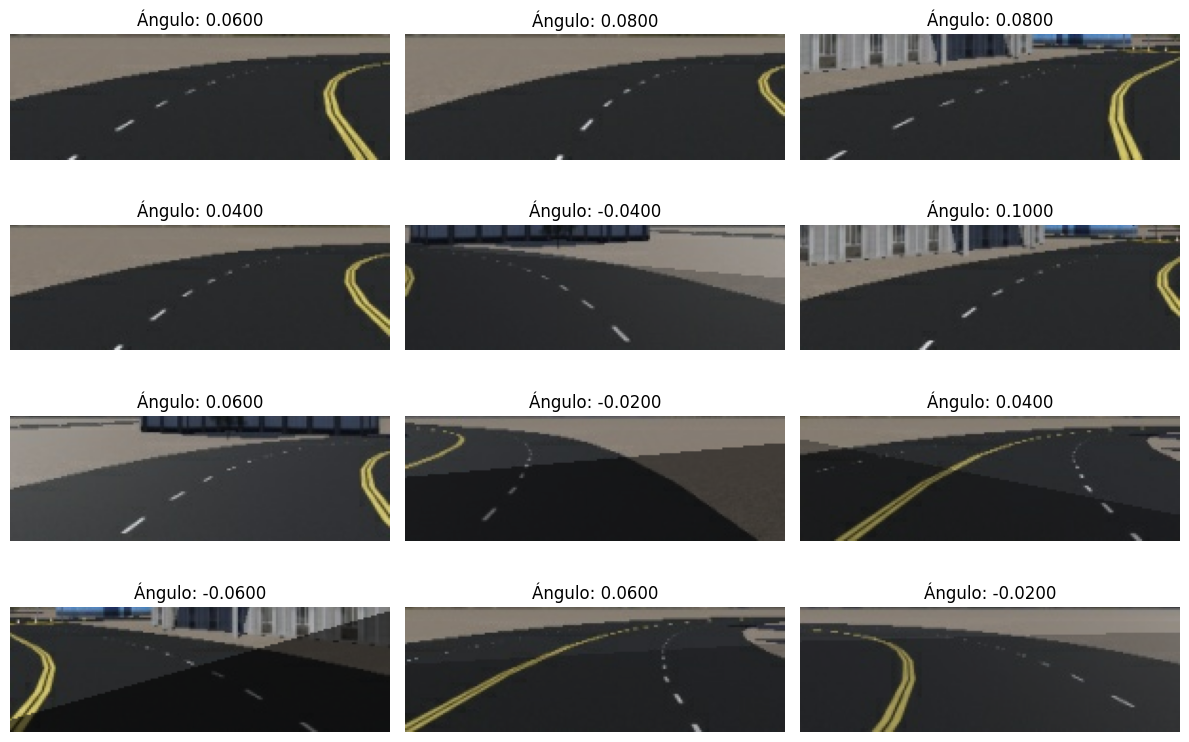

In [12]:
# A modo de ejemplo, mostramos 12 ejemplos de imágenes (originales y aumentadas)

# Tomamos un batch del dataset de entrenamiento (que incluye augmentación)
images_batch, angles_batch = next(iter(train_ds))

# Seleccionamos las primeras 12 muestras
num_examples = 12
imgs = images_batch[:num_examples]
angs = angles_batch[:num_examples]

# Graficamos las 12 muestras
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axes = axes.flatten()

for img, ang, ax in zip(imgs, angs, axes):
    ax.imshow(img)
    ax.set_title(f"Ángulo: {ang.numpy():.4f}")  
    ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:

# Compilamos el modelo con optimizador, función de pérdida y métricas
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss      = 'mse',        # error cuadrático medio para regresión de ángulo
    metrics   = ['mae']       # error absoluto medio como métrica adicional
)

# Definimos callbacks para guardar el mejor modelo y detenerse temprano
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, save_format='keras'),

    # Condicion de parada temprana en caso de que el modelo no mejore por 5 epochs consecutivos
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print("Modelo compilado y listo para entrenar")

Modelo compilado y listo para entrenar


In [14]:
# Inicamos el entrenamiento del modelo

# Iniciar el entrenamiento
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs          = 20,
        callbacks       = callbacks
    )

    print("Entrenamiento completado")

Epoch 1/20


2025-06-21 01:59:16.266958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-21 01:59:18.443546: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f487c87e730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-21 01:59:18.443613: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2025-06-21 01:59:18.453802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750471158.585698    3742 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


711/711 [==============================] - 89s 112ms/step - loss: 0.0883 - mae: 0.2023 - val_loss: 0.0068 - val_mae: 0.0650
Epoch 2/20
711/711 [==============================] - 18s 26ms/step - loss: 0.0094 - mae: 0.0738 - val_loss: 0.0038 - val_mae: 0.0483
Epoch 3/20
711/711 [==============================] - 18s 26ms/step - loss: 0.0050 - mae: 0.0549 - val_loss: 0.0028 - val_mae: 0.0411
Epoch 4/20
711/711 [==============================] - 19s 27ms/step - loss: 0.0036 - mae: 0.0469 - val_loss: 0.0024 - val_mae: 0.0379
Epoch 5/20
711/711 [==============================] - 19s 26ms/step - loss: 0.0030 - mae: 0.0424 - val_loss: 0.0022 - val_mae: 0.0353
Epoch 6/20
711/711 [==============================] - 18s 26ms/step - loss: 0.0026 - mae: 0.0391 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 7/20
711/711 [==============================] - 18s 26ms/step - loss: 0.0022 - mae: 0.0364 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 8/20
711/711 [==============================] - 20s 28ms/step - lo

In [15]:
# evaluar el modelo con el dataset de validación
loss, mae = model.evaluate(val_ds)

print(f"Loss: {loss:.4f}, MAE: {mae:.4f}")

237/237 [==============================] - 2s 9ms/step - loss: 9.0772e-04 - mae: 0.0228
Loss: 0.0009, MAE: 0.0228


In [16]:
# Guardamos el modelo en formato keras con CPU
# Esto es necesario para que el modelo se pueda cargar en cualquier dispositivo
# Despues se podrá cargar el modelo en GPU basado en el modelo guardado en CPU
with tf.device('/CPU:0'):
    model.save('best_model_cpu_v6.h5', overwrite=True)
    print("Modelo guardado en formato keras con CPU")

Modelo guardado en formato keras con CPU


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


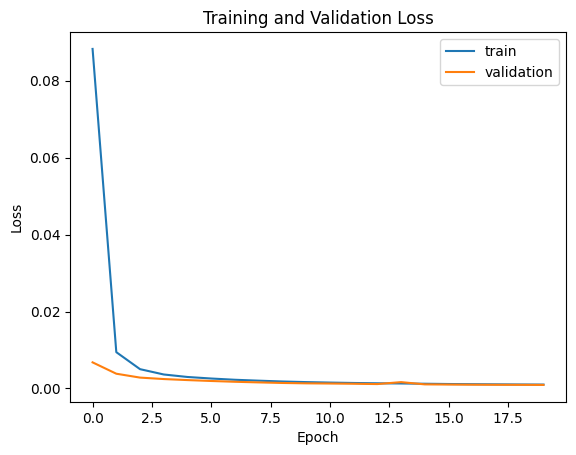

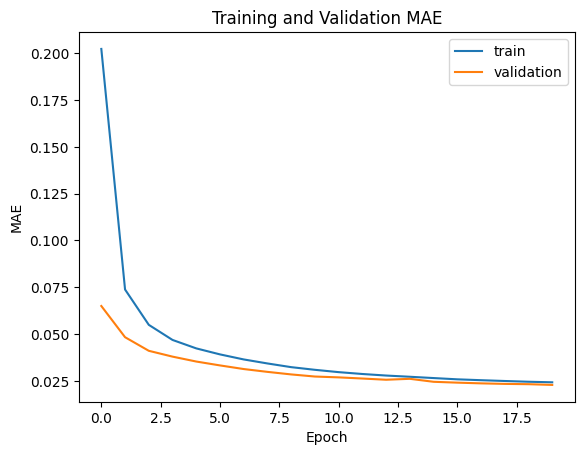

In [17]:
# Graficar Loss de entrenamiento y validación
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')  # título del gráfico
plt.ylabel('Loss')                          # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()

# Graficar MAE de entrenamiento y validación
plt.figure()
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training and Validation MAE')   # título del gráfico
plt.ylabel('MAE')                           # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()


# Experimento 2 - Transfer Learning basado en VGG16

In [40]:
# Capa para redimensionar y rellenar imágenes
class PadAndResize(layers.Layer):
    def __init__(self, pad_to=200, resize_to=224, **kwargs):
        super().__init__(**kwargs)
        self.pad_to = pad_to
        self.resize_to = resize_to

    def call(self, inputs):
        # inputs: tensor de forma (batch, 66, 200, 3)
        shape = tf.shape(inputs)
        height = shape[1]
        # calcular cuántos píxeles agregar arriba
        pad_top = self.pad_to - height  # 200 - 66 = 134
        # pad de 134 arriba, 0 abajo, 0/0 en ancho, 0 en canales
        padded = tf.image.pad_to_bounding_box(
            inputs,
            offset_height=pad_top,
            offset_width=0,
            target_height=self.pad_to,
            target_width=self.pad_to
        )
        # redimensionar de 200×200 a resize_to×resize_to
        resized = tf.image.resize(padded, [self.resize_to, self.resize_to])
        return resized

    def get_config(self):
        config = super().get_config()
        config.update({
            "pad_to": self.pad_to,
            "resize_to": self.resize_to
        })
        return config

In [41]:
def get_model_with_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    return tf.keras.Sequential([
        # Pad arriba y redimensionar a 224×224
        PadAndResize(pad_to=200, resize_to=224, input_shape=(66, 200, 3)),
        
        base_model,
        # Flatten the output to feed into the dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
    
        # Second fully connected layer
        layers.Dense(100, activation='relu'),
        layers.BatchNormalization(),
    
        # Third fully connected layer
        layers.Dense(50, activation='relu'),
        layers.BatchNormalization(),
    
        # Fourth fully connected layer
        layers.Dense(10, activation='relu'),
    
        # Output layer
        layers.Dense(1)
    ])

In [43]:
# Mostramos una version del modelo basado en vgg16
model_2_vgg = get_model_with_vgg16()

# Mostramos la estructura del modelo
model_2_vgg.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pad_and_resize (PadAndResi  (None, 224, 224, 3)       0         
 ze)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 100)               2508900   
                                                                 
 batch_normalization_24 (Ba  (None, 100)               

In [44]:
# Compilamos el modelo con optimizador, función de pérdida y métricas
model_2_vgg.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss      = 'mse',        # error cuadrático medio para regresión de ángulo
    metrics   = ['mae']       # error absoluto medio como métrica adicional
)

# Definimos callbacks para guardar el mejor modelo y detenerse temprano
callbacks_2 = [
    tf.keras.callbacks.ModelCheckpoint('best_model_vgg.keras', save_best_only=True, save_format='keras'),

    # Condicion de parada temprana en caso de que el modelo no mejore por 5 epochs consecutivos
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [45]:
# Iniciamos el entrenamiento del modelo basado en vgg16

history_2 = model_2_vgg.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = 20,
    callbacks       = callbacks_2
)


Epoch 1/20
206/206 [==============================] - 85s 329ms/step - loss: 0.3219 - mae: 0.4323 - val_loss: 0.0572 - val_mae: 0.1962
Epoch 2/20
206/206 [==============================] - 58s 276ms/step - loss: 0.1364 - mae: 0.2890 - val_loss: 0.0728 - val_mae: 0.2273
Epoch 3/20
206/206 [==============================] - 49s 238ms/step - loss: 0.0899 - mae: 0.2345 - val_loss: 0.0474 - val_mae: 0.1633
Epoch 4/20
206/206 [==============================] - 51s 240ms/step - loss: 0.0659 - mae: 0.2001 - val_loss: 0.0313 - val_mae: 0.1407
Epoch 5/20
206/206 [==============================] - 58s 280ms/step - loss: 0.0493 - mae: 0.1730 - val_loss: 0.0291 - val_mae: 0.1320
Epoch 6/20
206/206 [==============================] - 51s 240ms/step - loss: 0.0394 - mae: 0.1547 - val_loss: 0.0161 - val_mae: 0.1006
Epoch 7/20
206/206 [==============================] - 51s 239ms/step - loss: 0.0311 - mae: 0.1374 - val_loss: 0.0153 - val_mae: 0.0987
Epoch 8/20
206/206 [==============================] - 5

In [46]:
# Guardamos el modelo en formato keras conå CPU
# Esto es necesario para que el modelo se pueda cargar en cualquier dispositivo
# Despues se podrá cargar el modelo en GPU basado en el modelo guardado en CPU
with tf.device('/CPU:0'):
    model_2_vgg.save('best_model_vgg_cpu.h5', overwrite=True)
    print("Modelo basado en vgg16 guardado en formato keras con CPU")

Modelo basado en vgg16 guardado en formato keras con CPU


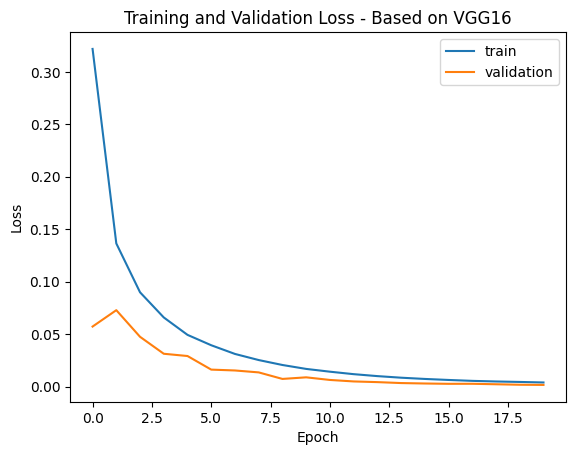

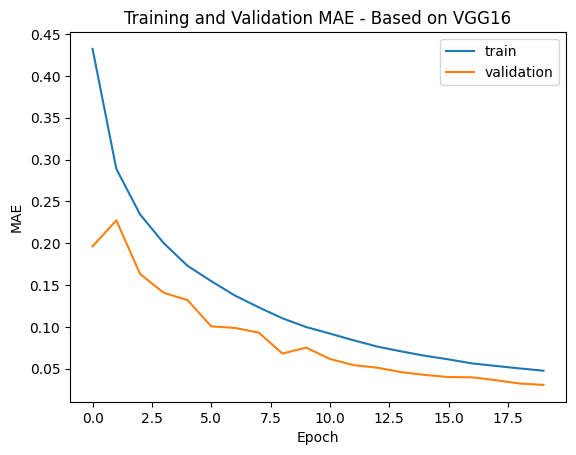

In [47]:
# Graficar Loss de entrenamiento y validación
plt.figure()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Training and Validation Loss - Based on VGG16')  # título del gráfico
plt.ylabel('Loss')                          # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()

# Graficar MAE de entrenamiento y validación
plt.figure()
plt.plot(history_2.history['mae'])
plt.plot(history_2.history['val_mae'])
plt.title('Training and Validation MAE - Based on VGG16')   # título del gráfico
plt.ylabel('MAE')                           # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()